In [1]:
import numpy as np
import pandas as pd
import os
import shap
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

## I should start by Exploring the dataset

In [2]:
# EDA

data = pd.read_csv("/kaggle/input/szeged-weather/weatherHistory.csv")
data.describe()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.0,96453.000000
mean,11.932678,10.855029,0.734899,10.810640,187.509232,10.347325,0.0,1003.235956
std,9.551546,10.696847,0.195473,6.913571,107.383428,4.192123,0.0,116.969906
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,0.0,1011.900000
50%,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,0.0,1016.450000
75%,18.838889,18.838889,0.890000,14.135800,290.000000,14.812000,0.0,1021.090000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,0.0,1046.380000


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
Formatted Date              96453 non-null object
Summary                     96453 non-null object
Precip Type                 95936 non-null object
Temperature (C)             96453 non-null float64
Apparent Temperature (C)    96453 non-null float64
Humidity                    96453 non-null float64
Wind Speed (km/h)           96453 non-null float64
Wind Bearing (degrees)      96453 non-null float64
Visibility (km)             96453 non-null float64
Loud Cover                  96453 non-null float64
Pressure (millibars)        96453 non-null float64
Daily Summary               96453 non-null object
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


In [4]:
data.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


## I will simplify the dataset by taking only several columns and making it daily instead of hourly.

In [5]:
daily_average_data = pd.DataFrame()
c = 0
for i in range(len(data)):
    if (i % 24 == 1):
        daily_average_data.loc[c,"Date"] = data["Formatted Date"][i].split(" ")[0]
        daily_average_data.loc[c,"Temperature"] = np.mean(data["Temperature (C)"][i:i+24])
        daily_average_data.loc[c,"Humidity"] = np.mean(data["Humidity"][i:i+24])
        daily_average_data.loc[c,"Wind_Speed"] = np.mean(data["Wind Speed (km/h)"][i:i+24])
        daily_average_data.loc[c,"Visibility"] = np.mean(data["Visibility (km)"][i:i+24])
        daily_average_data.loc[c,"Pressure"] = np.mean(data["Pressure (millibars)"][i:i+24])
        c += 1
        
daily_average_data.sort_values(by=['Date'], inplace=True, ascending=True)
daily_average_data = daily_average_data.reset_index(drop=True)

In [6]:
daily_average_data.head() # sorted and easy to work on

,Date,Temperature,Humidity,Wind_Speed,Visibility,Pressure
0,2006-01-01,3.798843,0.816667,20.787783,11.112354,1012.967083
1,2006-01-02,4.965741,0.843750,17.264567,8.800663,1010.879583
2,2006-01-03,2.218287,0.891250,8.029875,9.034783,1021.492917
3,2006-01-04,2.251852,0.906667,12.152817,8.352546,981.770833
4,2006-01-05,2.703935,0.951250,8.991179,4.308092,935.873750


## Now I can design the dataset into more trainable sliding windows format.

In [7]:
# 20 days of data to predict 21st day?

In [8]:
N = 10
columns = []
for i in range(N,0,-1):
    columns.append("N - " + str(i)) 

columns.append("N")
columns.append("N + 1")

In [9]:
Train_data = pd.DataFrame(columns=columns)
Train_data   # n + 1 represents tomorrow

,N - 10,N - 9,N - 8,N - 7,N - 6,N - 5,N - 4,N - 3,N - 2,N - 1,N,N + 1


In [32]:
for i in range(len(daily_average_data)-11):
        Train_data.loc[i, "N - 10"] = daily_average_data["Temperature"][i]
        Train_data.loc[i, "N - 9"] = daily_average_data["Temperature"][i+1]
        Train_data.loc[i, "N - 8"] = daily_average_data["Temperature"][i+2]
        Train_data.loc[i, "N - 7"] = daily_average_data["Temperature"][i+3]
        Train_data.loc[i, "N - 6"] = daily_average_data["Temperature"][i+4]
        Train_data.loc[i, "N - 5"] = daily_average_data["Temperature"][i+5]
        Train_data.loc[i, "N - 4"] = daily_average_data["Temperature"][i+6]
        Train_data.loc[i, "N - 3"] = daily_average_data["Temperature"][i+7]
        Train_data.loc[i, "N - 2"] = daily_average_data["Temperature"][i+8]
        Train_data.loc[i, "N - 1"] = daily_average_data["Temperature"][i+9]
        Train_data.loc[i, "N"] = daily_average_data["Temperature"][i+10]
        Train_data.loc[i, "N + 1"] = daily_average_data["Temperature"][i+11]

In [33]:
Train_data.head()  # sliding window. N is current day and we take the previous days. 
# Those days then is going to be used for predicting the tomorrow which is labelled N+1

,N - 10,N - 9,N - 8,N - 7,N - 6,N - 5,N - 4,N - 3,N - 2,N - 1,N,N + 1
0,3.79884,4.96574,2.21829,2.25185,2.70394,2.55046,0.877083,-1.23171,-0.902315,-0.532639,-1.39236,-0.341898
1,4.96574,2.21829,2.25185,2.70394,2.55046,0.877083,-1.23171,-0.902315,-0.532639,-1.39236,-0.341898,-0.357176
2,2.21829,2.25185,2.70394,2.55046,0.877083,-1.23171,-0.902315,-0.532639,-1.39236,-0.341898,-0.357176,-1.134722
3,2.25185,2.70394,2.55046,0.877083,-1.23171,-0.902315,-0.532639,-1.39236,-0.341898,-0.357176,-1.13472,-3.135648
4,2.70394,2.55046,0.877083,-1.23171,-0.902315,-0.532639,-1.39236,-0.341898,-0.357176,-1.13472,-3.13565,-3.639815


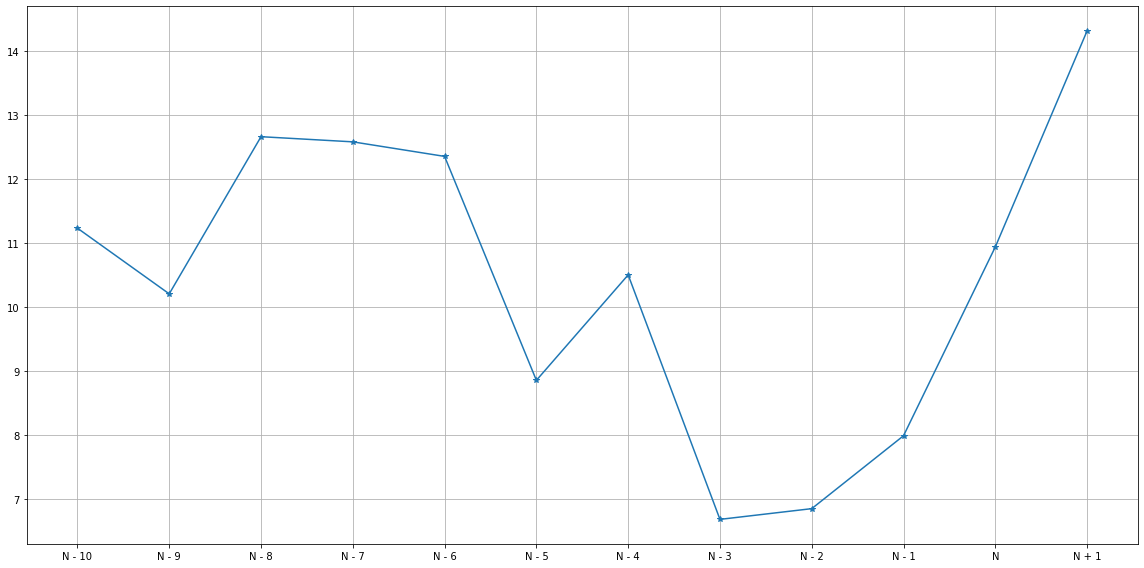

In [34]:
plt.figure(figsize=(16,8))
plt.plot(Train_data.iloc[88],"-*")
plt.grid()
plt.tight_layout()

In [35]:
Train_data.shape

(4008, 12)

In [36]:
train_y = Train_data["N + 1"]

Train_data.drop(["N + 1"],axis=1,inplace=True)

train_x = Train_data

TypeError: Invalid parameters passed: {'validation_size': 0.25}

In [38]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(train_x,train_y)

In [39]:
print("shape of training dataset features: ",train_x.shape)
print("shape of training dataset labels: ",train_y.shape)
print("shape of testing dataset features: ",test_x.shape)
print("shape of testing dataset labels: ",test_y.shape)

shape of training dataset features:  (3006, 11)
shape of training dataset labels:  (3006,)
shape of testing dataset features:  (1002, 11)
shape of testing dataset labels:  (1002,)


In [40]:
print("features \n",train_x.iloc[88])
print("\n label \n", train_y.iloc[88])

features 
 N - 10    7.33727
N - 9     9.23194
N - 8     9.37083
N - 7     14.1873
N - 6     13.6479
N - 5     16.7734
N - 4     18.0984
N - 3     13.8514
N - 2     14.4301
N - 1     14.7102
N         14.2845
Name: 290, dtype: object

 label 
 13.18587962962963


In [41]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()

In [42]:
model.fit(train_x,train_y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [43]:
pred_y = model.predict(test_x)
from sklearn.metrics import r2_score

r2_score(test_y,pred_y)

AttributeError: 'RandomForestRegressor' object has no attribute 'evaluate'

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


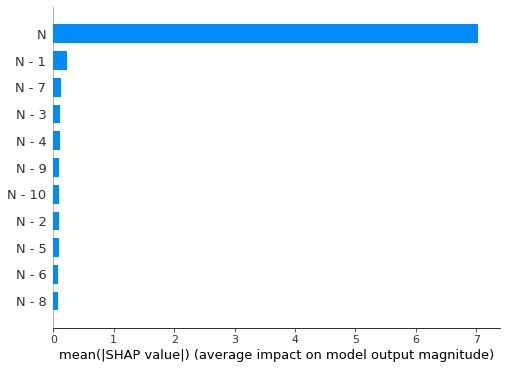

In [18]:
shap_values = shap.TreeExplainer(model).shap_values(train_x)
shap.summary_plot(shap_values, train_x, plot_type="bar");

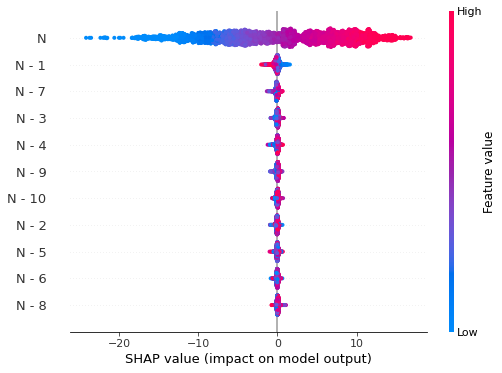

In [19]:
f = plt.figure()
shap.summary_plot(shap_values, train_x)